<a href="https://colab.research.google.com/github/fipaniagua/IIC3697-Deep-Learning/blob/develop/IIC3697-Deep-Learning/LSTM%20RNN%20and%20attention%20with%20Pytorch/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 2: Redes Neuronales Recurrentes (RNNs)

Francisco Paniagua


##Parte 1: RNNs

### Actividad 1


En primer lugar Implementamos el modelo RNN *many-to-one*

In [0]:
import torch
import torch.nn as nn

In [0]:
class RNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers):
    super().__init__() 
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers 
    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers)
    self.linear_out = nn.Linear(hidden_dim, 1)
  
  # This method defines the forward pass of the RNN 
  def forward(self, input):
    _ , batch_size, _ = input.size()
    # Initializing hidden state for first input 
    h0 = self.init_hidden(batch_size) 
    # Passing in the input and hidden state to obtain output 
    _, hidden_state = self.rnn(input, h0) 
    out = self.linear_out(hidden_state.squeeze())
    return out

  # This method generates the first hidden state of zeros for the forward pass 
  # This creates a tensor of zeros in the shape of our hidden states. 
  def init_hidden(self, batch_size): 
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    return hidden

Podemos notar que la cantidad de parametros de nuestro modelo RNN depende de tres hiper parametros principales:


1.   Input dimension
2.   Hidden dimension
3.   Number of layers

Debido a esto si fijamos la deminsión interna a 100 y solo una capa oculta, el unico parametro que podemos varias es `la dimensión de entrada`. Como la dimension de entrada depende del **embeding** y este a su vez depende del **vocabulario** podemos argumentar que dependiendo del dataset podria cambiar la cantidad de parametros necesarios.

Ahora bien, el embeding no solo depende del vocabulario sino tambien depende de la desición de con cuanta información nos queremos quedar para representar nuestro input. Esto genera un *trade-off* entre la cantidad de parametros y la cantidad de información que queremos "guardar".  

A continuación un grafico que muestra esta relación (con modelos de capa oculta de una dimension de 100 y otro de 50).



In [0]:
def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
posible_input_dimensions = [10**i for i in range(1,7)]
num_parameters_100 = []
num_parameters_50 = []
for input_dimension in posible_input_dimensions:
  parameters_100 = num_trainable_parameters(RNN(input_dimension, 100, 1))
  parameters_50 = num_trainable_parameters(RNN(input_dimension, 50, 1))
  num_parameters_100.append(parameters_100)
  num_parameters_50.append(parameters_50)
  print("{0} | {1} | {2} | {3}".format(
      input_dimension,
      parameters_50,
      parameters_100,
      parameters_100/parameters_50
  ))

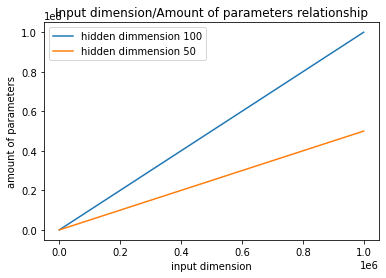

In [0]:
import matplotlib.pyplot as plt

plt.plot(posible_input_dimensions, num_parameters_100)
plt.plot(posible_input_dimensions, num_parameters_50)
plt.title("Input dimension/Amount of parameters relationship")
plt.xlabel("input dimension")
plt.ylabel("amount of parameters")
plt.legend(["hidden dimmension 100", "hidden dimmension 50"], loc='upper left')
plt.show()

dimension de entrada | cantidad de parametros (capa interna 50) | cantidad de parametros (capa interna 100) | relación entre modelo de capa interna 50 y 100
--- | --- | --- | --- |  
10 | 3151 | 11301 | 3.586480482386544
100 | 7651 | 20301 | 2.6533786433145994
1000 | 52651 | 110301 | 2.0949459649389377
10000 | 502651 | 1010301 | 2.0099452701775187
100000 | 5002651 | 10010301 | 2.000999270186947
1000000 | 50002651 | 100010301 | 2.0000999746993413

Es claro en el grafico que existe una relación lineal entre la cantidad de parametros y la dimensión de entrada. Ademas al disminuir a 50 la dimension interna, la cantidad de parametros tiende a disminuir a la mitad a medida que aumentamos la dimension de entrada.

Podemos confirmar esta relación teoricamente tambien. La cantidad de parametros puede ser calculada de la siguiente forma:

\begin{align}
parametros_{totales} & = Parametros_{Rnn Cell} + Parametros_{Capa final}\\
parametros_{totales} & = \{\#(W_{ih}) + \#(b_{ih}) + \#(W_{hh}) + \#(b_{hh})\} + \{\#(W_{h1}) + \#(b_{1}) \}  \\
parametros_{totales} & = (h*i + h + h*h + h) + (h*1 + 1)\\
parametros_{totales} & = h(i+ h + 3) +1 \\
parametros_{totales} & = h^2 + 3h + h*i + 1
\end{align} 



Interesantemente, a pesar de que la cantidad de parametros aumenta cuadraticamente en relación a la dimensión interna. Si calculamos el limite cuando la dimension del input i tiende a infinito, El aumento porcentual de los parametros tiende a dos cuando duplicamos la dimensión interna (lo cual coincide con nuestros resultados empiricos):

\begin{align}
\lim_{i \to \infty} (4h^2+6h+2hi+1)/(h^2+3h+hi+1) = 2.
\end{align} 

Es decir, mientras mas grande es la dimension de la entrada, mas linealmente se comporta el aumento de parametros en razón del aumento de la dimensión interna


### Large Movie Review Dataset Preprocessing



In [0]:
import torch
from torchtext import data
from torchtext import datasets
torch.backends.cudnn.deterministic = True

In [6]:
TEXT = data.Field(tokenize = 'spacy', lower = True)
LABEL = data.LabelField(dtype = torch.float)
imdb_train_data, imdb_test_data = datasets.IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 34.2MB/s]


In [5]:
len(imdb_train_data)

25000

Para eliminar las palabras con error de ortogradia eliminaremos todas las palabras que tan solo salgan 1 o 2 veces. Como existen **59582** palabras que solo aparecen 1 o 2 veces, y el tamaño del vocabulario es 101520, tomaremos las primeras 35000 palabras


In [7]:
MAX_VOCAB_SIZE = 35000
TEXT.build_vocab(imdb_test_data, max_size = MAX_VOCAB_SIZE, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
#TEXT.build_vocab(imdb_test_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(imdb_test_data)

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                          
100%|█████████▉| 398180/400000 [00:16<00:00, 24310.64it/s]

In [97]:
len(list(filter(lambda freq: (freq == 2 or freq == 1),  TEXT.vocab.freqs.values())))

58662

In [9]:
print(f"tokens unicos dentro del vocabulario: {len(TEXT.vocab)}")

tokens unicos dentro del vocabulario: 35002


In [0]:
BATCH_SIZE = 64

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

imdb_train_iterator,  imdb_test_iterator = data.BucketIterator.splits(
    (imdb_train_data,  imdb_test_data), 
    batch_size = BATCH_SIZE,
    device = device)

### Actividad 2


En primer lugar crearemos una clase FULLRNN que contendra el embeding junto a la capa de la red neuronal recurrente.

Esta clase puede crear usar una capa bidireccional si se cambia el parametro 'bidirectional'. Si esto sucede, es necesario cambiar tambien la ultima capa lineal, ya que ahora el input sera la concatenacion del estado oculto en ambas direcciones, por tanto, es necesario aumentar la dimension de la capa lineal en dos.


In [0]:
class FULLRNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, embedding_dim, pad_idx, bidirectional = False):
    super().__init__() 
    self.bidirectional = bidirectional 
    self.embedding_dim = embedding_dim
    self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers 
    self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, bidirectional = bidirectional)
    self.in_layer_dim = hidden_dim
    if (bidirectional):
      self.in_layer_dim = 2 * self.in_layer_dim
    self.linear_out = nn.Linear(self.in_layer_dim, 1)
  
  # This method defines the forward pass of the RNN 
  def forward(self, input):
    #input = [sent len, batch size]
    _ , batch_size = input.size()
    # Initializing hidden state for first input 
    h0 = self.init_hidden(batch_size) 
    # Passing in the input and hidden state to obtain output 
    embedded = self.embedding(input)
    _, hidden_state = self.rnn(embedded, h0) 
    if (self.bidirectional):
      hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
      out = self.linear_out(hidden)
    else:  
      out = self.linear_out(hidden_state.squeeze())
    return (out, hidden_state)

  # This method generates the first hidden state of zeros for the forward pass 
  # This creates a tensor of zeros in the shape of our hidden states. 
  def init_hidden(self, batch_size):
    #print(f"create a hidden state of batch_size:{batch_size}") 
    if (self.bidirectional):
      hidden = torch.zeros(self.num_layers*2, batch_size, self.hidden_dim)
    else:
      hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    return hidden
  def add_pretrained_embeddings(self, TEXT_FIELD):
    self.embedding.weight.data.copy_(TEXT_FIELD.vocab.vectors) 
    PAD_IDX = TEXT_FIELD.vocab.stoi[TEXT.pad_token] 
    UNK_IDX = TEXT_FIELD.vocab.stoi[TEXT.unk_token]
    self.embedding.weight.data[UNK_IDX] = torch.zeros(self.embedding_dim)
    self.embedding.weight.data[PAD_IDX] = torch.zeros(self.embedding_dim)


In [0]:
def calc_accuracy(X,Y):
   #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(X))
    correct = (rounded_preds == Y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
def eval_model(model, iterator):
    accuracy = 0
    for batch in iterator:
      answ, hidden = model(batch.text)
      batch_acc = calc_accuracy(answ.squeeze(1), batch.label)
      accuracy += batch_acc
    return accuracy/len(iterator)  

Para mayor simplicidad crearemos la funcion run que nos permite entrenar un modelo dado un iterador (creado mediante el dataloader).
Luego de crear esta función probaremos distintos hiper-parametros y graficaremos los resultados (variación del acurracy a travez de las epocas) . Para finalmente crear una tabla comparativa entre todos los modelos probados

In [0]:
import time

def run(model, iterator, n_epochs = 20, lr=0.01, verbose=False):
    # Define hyperparameters: number of epochs and learning rate
    accurracy = []
    # Define device, in this case CPU
    # device = torch.device("cpu") model.to(device)
    # Define Loss, Optimizer, ex: cross entropy and Adam.
    criterion = nn.BCEWithLogitsLoss()
    criterion = criterion.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Run training 
    for epoch in range(1, n_epochs + 1):
        i = 0 
        epoch_acc = 0
        ti = time.time()
        print(f"epoca {epoch}")
        for batch in iterator: 
            i += 1
            # Reset gradients from previous epoch 
            tb = time.time()
            optimizer.zero_grad()
            # run model on inputs 
            batch.text.to(device) 
            #print(batch.text.shape)
            #print(batch.text[0])
            output, hidden = model(batch.text)
            # compute loss, run backprop, and update weights
            #print(output.squeeze(1).shape)
            batch.label.to(device)
            batch_acc = calc_accuracy(output.squeeze(1), batch.label)
            epoch_acc += batch_acc
            loss = criterion(output.squeeze(1),  batch.label) 
            loss.backward() 
            optimizer.step()
            if(verbose):
              print("batch: {0}/ accurracy {1}/ time: {2}".format(i, batch_acc,
                                                                  time.time()-  tb))
        accurracy.append(epoch_acc / len(imdb_train_iterator)) 
        print("tiempo entrenamiento epoca: {0}/ accurracy: {1}".format(time.time()-ti, 
        epoch_acc / len(imdb_train_iterator)))
    return accurracy

En las siguintes celdas se entrenan distintos modelos con distintos parametros (Al final de la sección se encuentra los resultados agregados)



* Modelo de una capa, no bidireccional, con una dimension interna de 50



In [69]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 50
NUM_LAYERS = 1

model = FULLRNN(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS ,EMBEDDING_DIM, TEXT.vocab.stoi[TEXT.pad_token])
model.add_pretrained_embeddings(TEXT)
model.to(device)

FULLRNN(
  (embedding): Embedding(35002, 100, padding_idx=1)
  (rnn): RNN(100, 50)
  (linear_out): Linear(in_features=50, out_features=1, bias=True)
)

In [38]:
acc = run(model, imdb_train_iterator, n_epochs=5)

epoca 1
tiempo entrenamiento epoca: 165.0138716697693/ accurracy: 0.501838207244873
epoca 2
tiempo entrenamiento epoca: 165.3033049106598/ accurracy: 0.494733065366745
epoca 3
tiempo entrenamiento epoca: 173.6122179031372/ accurracy: 0.5030450820922852
epoca 4
tiempo entrenamiento epoca: 183.8861083984375/ accurracy: 0.5049392580986023
epoca 5
tiempo entrenamiento epoca: 194.84948205947876/ accurracy: 0.49832960963249207


In [0]:
import matplotlib.pyplot as plt

In [40]:
eval_model(model, imdb_test_iterator)

tensor(0.4763)



*  Modelo en donde se varia la dimensión interna a 100 pero sigue siendo en una sola dirección



In [41]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
NUM_LAYERS = 1

model2 = FULLRNN(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS ,EMBEDDING_DIM, TEXT.vocab.stoi[TEXT.pad_token])
model2.add_pretrained_embeddings(TEXT)
model2.to(device)

FULLRNN(
  (embedding): Embedding(35002, 100, padding_idx=1)
  (rnn): RNN(100, 100)
  (linear_out): Linear(in_features=100, out_features=1, bias=True)
)

In [42]:
acc = run(model2, imdb_train_iterator, n_epochs = 5)

epoca 1
tiempo entrenamiento epoca: 243.5650634765625/ accurracy: 0.4988331198692322
epoca 2
tiempo entrenamiento epoca: 215.6640899181366/ accurracy: 0.5018782019615173
epoca 3
tiempo entrenamiento epoca: 247.0492341518402/ accurracy: 0.5016463994979858
epoca 4
tiempo entrenamiento epoca: 255.94598269462585/ accurracy: 0.4992806911468506
epoca 5
tiempo entrenamiento epoca: 259.4289884567261/ accurracy: 0.4997362792491913


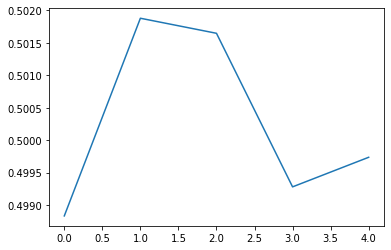

In [43]:
plt.plot(acc)

In [45]:
eval_model(model2, imdb_test_iterator)

tensor(0.5695)



*  Este modelo incluye una RNN bidireccional de una capa, ademas se vario la dimension de los embeddings a 150



In [73]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 150
HIDDEN_DIM = 50
NUM_LAYERS = 1
BIDIRECTIONAL = True

model3 = FULLRNN(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS ,EMBEDDING_DIM, TEXT.vocab.stoi[TEXT.pad_token],
                 BIDIRECTIONAL)
#model3.add_pretrained_embeddings(TEXT)
model3.to(device)

FULLRNN(
  (embedding): Embedding(35002, 150, padding_idx=1)
  (rnn): RNN(150, 50, bidirectional=True)
  (linear_out): Linear(in_features=100, out_features=1, bias=True)
)

In [74]:
acc3 = run(model3, imdb_train_iterator, n_epochs = 5)

epoca 1
tiempo entrenamiento epoca: 405.25824332237244/ accurracy: 0.5594469308853149
epoca 2
tiempo entrenamiento epoca: 380.83515071868896/ accurracy: 0.6529411673545837
epoca 3
tiempo entrenamiento epoca: 371.2245943546295/ accurracy: 0.6980578303337097
epoca 4
tiempo entrenamiento epoca: 355.8866751194/ accurracy: 0.7355977892875671
epoca 5
tiempo entrenamiento epoca: 367.8403160572052/ accurracy: 0.7567934989929199


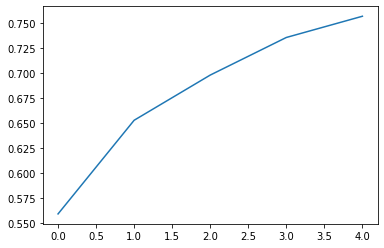

In [75]:
plt.plot(acc3)

In [76]:
eval_model(model3, imdb_test_iterator)

tensor(0.6633)

*   Este ultimo modelo tiene dos capas dentro de la red neuronal recurrente, ademas es bidireccional



In [80]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 150
HIDDEN_DIM = 50
NUM_LAYERS = 2
BIDIRECTIONAL = True

model4 = FULLRNN(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS ,EMBEDDING_DIM, TEXT.vocab.stoi[TEXT.pad_token],
                 BIDIRECTIONAL)
#model4.add_pretrained_embeddings(TEXT)
model4.to(device)

FULLRNN(
  (embedding): Embedding(35002, 150, padding_idx=1)
  (rnn): RNN(150, 50, num_layers=2, bidirectional=True)
  (linear_out): Linear(in_features=100, out_features=1, bias=True)
)

In [81]:
acc4 = run(model4, imdb_train_iterator, n_epochs = 5)

epoca 1
tiempo entrenamiento epoca: 1035.049869298935/ accurracy: 0.55535489320755
epoca 2
tiempo entrenamiento epoca: 831.1738274097443/ accurracy: 0.6449089050292969
epoca 3
tiempo entrenamiento epoca: 778.287401676178/ accurracy: 0.7044277191162109
epoca 4
tiempo entrenamiento epoca: 824.7165851593018/ accurracy: 0.7256473898887634
epoca 5
tiempo entrenamiento epoca: 703.8238232135773/ accurracy: 0.7336477041244507


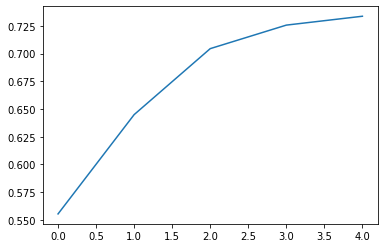

In [82]:
plt.plot(acc4)

In [83]:
eval_model(model4, imdb_test_iterator)

tensor(0.6185)

Finalmente luego de probar todos lo modelos obtenemos los siguientes resultados:


 Modelo | Tamaño Interno | Tamaño Embedding | Embedding Preentrenado | Capas RNN | Bidireccional |Acc Training | Acc Test | Epocas | Tiempo Entrenamiento
 --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
1 | 50 | 100 | si | 1 | no | 49%  | 47% | 5 | 14min
2 |  100 | 100 | si | 1 | no | 49% | 56% | 5 | 20min
3 | 50 | 150 | no | 1 | si  | 75% | 66% | 5 | 30min
4 | 50 | 150 | no | 1 | si | 73% | 61% | 5 | 66min


Si analizamos la tabla podemos ver que los modelos 1 y 2, a pesar de ser los unicos en tener un embedding preentrenado, obtuvieron los peores resultados.  Luego podemos notar que transformar la RNN a una biderccional, aumenta el tiempo de entrenamiento, pero mejora el rendimiento considerablemente. Finalmente podemos darnos cuenta que agregar una capa mas de profundidad a la RNN no ayudo en mejorar el rendimiento y aumento el tiempo  de entrenamiento al doble

###Actividad 3

En esta sección resolveremos el mismo problema, pero en vez de utilizar una RNN "normal" usaremos un LSTM. El codigo de las siguientes celdas implementa este nuevo modelo y ademas entrena dos modelos con distintos hiper-parametros. (el tiempo de entrenamiento aumenta considerablemente en relación a una RNN normal).

Al igual que en la actividad 2, al final de la sección se encuentra una tabla comparativa

In [0]:
class FULLLSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, embedding_dim, bidirectional, pad_idx):
    super().__init__() 
    self.embedding_dim = embedding_dim
    self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers 
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                       bidirectional = bidirectional,
                        dropout=0.45)
    self.linear_out = nn.Linear(hidden_dim*2, 1)
  
  # This method defines the forward pass of the RNN 
  def forward(self, input):
    #input = [sent len, batch size]
    _ , batch_size = input.size()
    # Passing in the input and hidden state to obtain output 
    embedded = self.embedding(input)
    _, (hidden_state, cell_state) = self.lstm(embedded) 
    hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
    out = self.linear_out(hidden)
    return (out, hidden)

  # This method generates the first hidden state of zeros for the forward pass 
  # This creates a tensor of zeros in the shape of our hidden states. 
  def init_hidden(self, batch_size):
    #print(f"create a hidden state of batch_size:{batch_size}") 
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    return hidden
  def add_pretrained_embeddings(self, TEXT_FIELD):
    self.embedding.weight.data.copy_(TEXT_FIELD.vocab.vectors) 
    PAD_IDX = TEXT_FIELD.vocab.stoi[TEXT.pad_token] 
    UNK_IDX = TEXT_FIELD.vocab.stoi[TEXT.unk_token]
    self.embedding.weight.data[UNK_IDX] = torch.zeros(self.embedding_dim)
    self.embedding.weight.data[PAD_IDX] = torch.zeros(self.embedding_dim)


*  Modelo bidireccional de una LSTM con 2 capas (se entrena solo por 2 epocas)



In [18]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 50
N_LAYERS = 2
BIDIRECTIONAL = True

modellstm = FULLLSTM(len(TEXT.vocab), 
            HIDDEN_DIM,
            N_LAYERS,
            EMBEDDING_DIM, 
            BIDIRECTIONAL,
            TEXT.vocab.stoi[TEXT.pad_token])
modellstm.add_pretrained_embeddings(TEXT)
modellstm.to(device)

FULLLSTM(
  (embedding): Embedding(35002, 100, padding_idx=1)
  (lstm): LSTM(100, 50, num_layers=2, dropout=0.45, bidirectional=True)
  (linear_out): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
acclstm = run(modellstm, imdb_train_iterator, n_epochs = 2, verbose=True)

epoca 1
batch: 1/ accurracy 0.546875/ time: 12.479676246643066
batch: 2/ accurracy 0.515625/ time: 13.155879974365234
batch: 3/ accurracy 0.390625/ time: 9.448016881942749
batch: 4/ accurracy 0.53125/ time: 10.571600675582886
batch: 5/ accurracy 0.421875/ time: 11.345671892166138
batch: 6/ accurracy 0.453125/ time: 9.67387318611145
batch: 7/ accurracy 0.484375/ time: 10.571341753005981
batch: 8/ accurracy 0.515625/ time: 10.850731611251831
batch: 9/ accurracy 0.53125/ time: 11.374361515045166
batch: 10/ accurracy 0.40625/ time: 10.971382141113281
batch: 11/ accurracy 0.578125/ time: 10.719016075134277
batch: 12/ accurracy 0.4375/ time: 9.317959785461426
batch: 13/ accurracy 0.515625/ time: 8.353887557983398
batch: 14/ accurracy 0.546875/ time: 10.152477502822876
batch: 15/ accurracy 0.625/ time: 9.647545099258423
batch: 16/ accurracy 0.59375/ time: 12.675363540649414
batch: 17/ accurracy 0.53125/ time: 7.958718299865723
batch: 18/ accurracy 0.5625/ time: 9.067664384841919
batch: 19/ ac

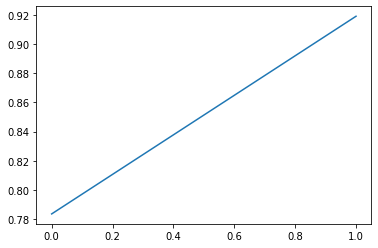

In [22]:
plt.plot(acclstm)

In [33]:
eval_model(modellstm, imdb_test_iterator)

tensor(0.8583)

* Modelo de LSTM pero con tan solo 1 capa y bidireccional (se entrena con tan solo 4 epocas)

In [15]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 50
N_LAYERS = 1
BIDIRECTIONAL = True

modellstm2 = FULLLSTM(len(TEXT.vocab), 
            HIDDEN_DIM,
            N_LAYERS,
            EMBEDDING_DIM, 
            BIDIRECTIONAL,
            TEXT.vocab.stoi[TEXT.pad_token])
modellstm2.add_pretrained_embeddings(TEXT)
modellstm2.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


FULLLSTM(
  (embedding): Embedding(35002, 100, padding_idx=1)
  (lstm): LSTM(100, 50, dropout=0.45, bidirectional=True)
  (linear_out): Linear(in_features=100, out_features=1, bias=True)
)

In [16]:
acclstm2 = run(modellstm2, imdb_train_iterator, n_epochs = 4, verbose=False)

epoca 1
tiempo entrenamiento epoca: 1222.0030992031097/ accurracy: 0.8194453716278076
epoca 2
tiempo entrenamiento epoca: 1188.3723623752594/ accurracy: 0.9333119988441467
epoca 3
tiempo entrenamiento epoca: 1590.0891089439392/ accurracy: 0.9682304859161377
epoca 4
tiempo entrenamiento epoca: 1492.7478249073029/ accurracy: 0.9809383153915405


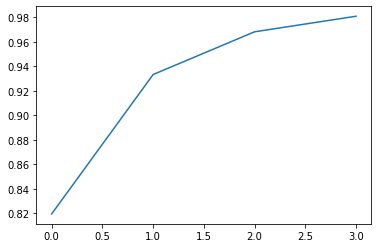

In [20]:
plt.plot(acclstm2)

In [21]:
eval_model(modellstm2, imdb_test_iterator)

tensor(0.8432)

Finalmente luego del arduo entrenamiento, obtenemos los siguientes resultados, que son bastante mejores que los obtenidos en la Actividad 2



 Modelo | Tamaño Interno | Tamaño Embedding | Embedding Preentrenado | Capas RNN | Bidireccional |Acc Training | Acc Test | Epocas | Tiempo Entrenamiento
 --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
5 | 50 | 100 | no | 2 |  si | 91% | 85% | 2 | 1.8 horas
6 | 50 | 100 | no | 1 | si | 98% | 84% | 4 | 1.5 horas

Al Revisar estos resultados, Podemos notar que obtenemos resultados considerablemente mejores con una LSTM, sin embargo, al tener mas parametros, el tiempo de entrenamiento aumenta tambien considerablemente. 

Cabe mencionar que el modelo 6, a pesar de tener un *accuracy* 7% mayor al modelo 5, obitene resultados levemente peores, esto podria ser una sañeal de que existe **overfitting** devido a que tiene mas epocas para sobreentrenarse.


## Parte 2: Modelos de Secuencia a Secuencia (Seq2Seq)


### SCAN Dataset Preprocessing

In [0]:
from torch.utils.data import Dataset, DataLoader
import torch
import itertools

In [0]:
class SimpleScanDataset(Dataset):
  
  def __init__(self, txt_dir):
    self.text_dir = txt_dir
    self.samples = []
    self.inVocab = {"<Pad>": 0 , "<Start>": 1, "<UNK>": 2}
    self.outVocab = {"<Pad>": 0 , "<Start>": 1, "<UNK>": 2}
    with open(txt_dir, mode="r") as file:
      for line in file.readlines():
        words = line.split(" ")
        raw_in_commands = list(itertools.takewhile(lambda word: word != "OUT:", words[1:]))
        raw_out_commands = list(itertools.dropwhile(lambda word: word!= "OUT:", words))
        in_commands = [self.to_vocab(token, "origin") for token in raw_in_commands]
        out_commands = [self.to_vocab(token, "final") for token in raw_out_commands[1:]]
        #print(raw_out_commands[1:])
        #print(out_commands)
        sample = {"IN": in_commands, "OUT": out_commands }
        self.samples.append(sample)
  
  def __len__(self):
    return len(self.samples)

  def to_vocab(self, word, language = "origin" ):
    if language == "origin":
      if word not in self.inVocab:
        self.inVocab[word] = len(self.inVocab)  
      return self.inVocab[word]
    else:
      if word not in self.outVocab:
        self.outVocab[word] = len(self.outVocab)  
      return self.outVocab[word]

  def __getitem__(self, idx):
    return self.samples[idx]

In [0]:
def scan_collate(batch):
  in_commands = [item["IN"] for item in batch]
  out_commands = [item["OUT"] for item in batch]
  max_length_in = len(max(in_commands, key=lambda item: len(item)))
  max_length_out = len(max(out_commands, key=lambda item: len(item)))
  new_in_commands = []
  new_out_commands = []
  for in_command in in_commands:
    new_in_command = in_command
    if len(in_command) < max_length_in:
      new_in_command += [0]*(max_length_in-len(in_command))
    new_in_commands.append(new_in_command)  
  for out_command in out_commands:
    new_out_command = out_command
    if len(out_command) < max_length_out:
      new_out_command += [0]*(max_length_out-len(out_command))
    new_out_commands.append(new_out_command)  
  return {"IN": torch.tensor(new_in_commands), "OUT": torch.tensor(new_out_commands) }   

In [0]:
BATCH_SIZE = 32

trainScanDataset = SimpleScanDataset("drive/My Drive/SCAN/tasks_train_simple.txt")
train_scan_dataloader = DataLoader(trainScanDataset, batch_size=32,
                                   collate_fn= scan_collate, drop_last=True)


### Actividad 4

Con la ayuda del *objeto* **trainScanDataset** implmentado en la sección anterior podemos encontrar el tamaño del diccionario para el lenguaje de origen y lenguaje de destino. Cabe mencionar que para ambos vocabularios se incluyen las palabras del dataset + 2 palabras con carateres especiales (padding, star, unknown):



*   Vocabulario origen : 13 (palabras en el dataset) + 3 (caracteres especiales)
*   Elemento de la lista : 12 (palabras en el dataset) + 3 (caracteres especiales)



In [10]:
print(f"tamaño vocabulario origen: {len(trainScanDataset.inVocab)}")
print(f"tamaño vocabulario de destino: {len(trainScanDataset.outVocab)}")
print(f"cantidad de ejemplos en el set de entrenamiento: {len(trainScanDataset)}")

tamaño vocabulario origen: 16
tamaño vocabulario de destino: 15
cantidad de ejemplos en el set de entrenamiento: 16728


A continuacion se implmentara el encoder, el decoder y una clase que encapsula ambos modelos, luego con esta ultima clase podremos analizar la cantidad de parametros entrenables.

Implementación del encoder:
* Es clave notar que el tamaño de la salida es 2 veces el tamaño de la dimensión interna, devido a que se concatenan los estados en ambas direcciones.

In [0]:
class EncoderModule(nn.Module): 
    
    def __init__(self, embeddings_table, embeddings_size, hidden_size):
        super().__init__()
        self.embeddings_table = embeddings_table 
        self.embeddings_size = embeddings_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=embeddings_size, hidden_size=hidden_size,
                            bidirectional=True, batch_first=True)

    def forward(self, src_sentences, src_lengths):
        # TODO: calcule embeddings usando self.embeddings_table
        #print("input:", src_sentences.shape) input = [batch_size, seq_len]
        embeded = self.embeddings_table(src_sentences)

        #print("embeded:", embeded.shape) embded = [batch_size, seq_len, embeded_size]
        # TODO: ejecute self.lstm sobre los embeddings de las oraciones
        all_hidden_states, (last_hidden_states, last_cell_states) = self.lstm(embeded) 
        
        last_hidden = torch.cat((last_hidden_states[-2,:,:], last_hidden_states[-1,:,:]), dim = 1) #concatenamos el resultado devido a que es bidireccional
        last_cell = torch.cat((last_cell_states[-2,:,:], last_cell_states[-1,:,:]), dim = 1)
        return all_hidden_states, last_hidden, last_cell


Implementación del decoder:

In [0]:
class DecoderModule(nn.Module): 
    def __init__( self, embeddings_table, hidden_size, start_idx, dst_vocab_size, input_size):
        super().__init__()
        self.embeddings_table = embeddings_table 
        self.start_idx = torch.tensor(start_idx).to(device) 
        self.hidden_size = hidden_size
        
        # capa que mapee estado interno de decodificador a vocabulario de salida
        self.W_vocab = torch.nn.Linear(hidden_size, dst_vocab_size) # TODO: completar parametros
        
        # decodificador recurrente 
        self.lstm_cell = torch.nn.LSTMCell(input_size=input_size, hidden_size=hidden_size) # TODO: completar parametros
        
    def forward( self, all_enc_hidden_states, final_enc_hidden_states, final_enc_cell_states, max_sentence_length, batch_size):
        out = []
        # estado oculto (h, c) inicial para decodificador 
        state = (final_enc_hidden_states, final_enc_cell_states)

        # loop de decodificacion 
        y_t = self.embeddings_table(self.start_idx.repeat(batch_size))
        for i in range(max_sentence_length):
            state = self.lstm_cell(y_t, state)
            h_t, c_t = state 
            P_t = self.W_vocab(h_t) # TODO: calule logits de salida usando W_vocab 
            out.append(P_t)
            _, max_indices = P_t.max(dim=1) 
            y_t = self.embeddings_table(max_indices)
        
        
        return torch.stack(out, dim=1)


Implementamos tambien la seq2seq que incluye al encoder y al decoder

In [0]:
class Seq2Seq(nn.Module):

    def __init__(self, hidden_size, embedding_size, org_vocab_size, dst_vocab_size, start_idx):
      super().__init__()
      self.start_idx = start_idx
      self.hidden_size = hidden_size
      self.embedding_size = embedding_size
      self.inEmbedding = nn.Embedding(org_vocab_size, embedding_size)
      self.encoder = EncoderModule(self.inEmbedding, self.embedding_size, self.hidden_size)
      self.outEmbedding = nn.Embedding(dst_vocab_size, embedding_size)
      self.decoder = DecoderModule(self.outEmbedding, self.hidden_size*2, 
                                   self.start_idx, dst_vocab_size, embedding_size)
      
    def forward(self, input, max_sentence_length):

      batch_size, in_seq_len = input.shape
      all_hidden_states, last_hidden_states, last_cell_states = self.encoder(input, in_seq_len)
      #print(f"las_hidden_states {last_hidden_states.size()} last cell {last_cell_states.shape}")
      out = self.decoder(all_hidden_states, last_hidden_states,
                         last_cell_states, max_sentence_length, batch_size)

      return out

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
HIDEN_SIZE = 50
EMBEDDING_SIZE = 25
ORG_VOCAB_SIZE = 17
DST_VOCAB_SIZE = 16
START_IDX = 1

seq2seqModel = Seq2Seq(HIDEN_SIZE, EMBEDDING_SIZE, ORG_VOCAB_SIZE, DST_VOCAB_SIZE, START_IDX)

In [16]:
num_trainable_parameters(seq2seqModel)

84041

Finalmente como se puede ver en la celda superior, el modelo final de seq2seq (sin atención) con los siguientes hiper-parametros

Tamaño Interno LSTM Cell | Tamaño del Embedding | Numero de  Capas | Bidireccionalidad
--- | --- |--- | --- |
50 | 25 | 1 | si

tiene **84.041** parametros. La poca cantidad de parametros se explica por el pequeño tamaño del vocabulario y por tanto del Embedding tambien

### Actividad 5

Para poder determinar como va variando la precisión a lo largo del entrenamiento creamos la función `calc_seq_accuracy` que dado dos vectores A y B. permite calcular el accurracy. A es un vector con las predicciones para cada una de las palabras de la sequencia y B contiene la codificacion (segun el vocab.) del groundtruth. 

Por esta razón se calcula para cada una de las palabras de la sequencia el indice del maximo de cada vector de A, (representa la predicción del modelo) y se compara con el valor de B correspondiente. Si calzan entonces la predicción fue correcta, y el acurracy aumenta proporcinoalmente (e.g. si se predicen la mita de la palbras de la secuencia correctamente se obtiene un accuracy del 50%)

In [0]:
def calc_seq_accuracy(X,Y):
   #round predictions to the closest integer
    rounded_preds = (torch.sigmoid(X))
    corrects = 0
    for idx in range(len(rounded_preds)):
      max_pred = torch.argmax(rounded_preds[idx])
      #print(max_pred.item(), "--" ,Y[idx])
      if max_pred.item() == Y[idx]:
        corrects += 1      
    acc = corrects/ len(rounded_preds)
    #print("calc_acc", acc)  
    return acc

Es necesario crear una nueva función run ya que el criterio de perdida cambia a **CrossEntropy** para cada una de las predicciones de cada palabra de cada secuencia.

In [0]:
import time

def run2(model, iterator, n_epochs = 20,  verbose=False):
    # Define hyperparameters: number of epochs and learning rate
    accurracy = []
    # Define device, in this case CPU
    # device = torch.device("cpu") model.to(device)
    # Define Loss, Optimizer, ex: cross entropy and Adam.
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    # Run training 
    for epoch in range(1, n_epochs + 1):
        i = 0 
        epoch_acc = 0
        ti = time.time()
        print(f"epoca {epoch}")
        for batch in iterator: 
            i += 1
            batch_acc = 0
            # Reset gradients from previous epoch 
            tb = time.time()
            optimizer.zero_grad()
            # run model on inputs 
            input_batch = batch["IN"]
            output_batch = batch["OUT"]
            batch_size, seq_out_len = output_batch.size()
            output = model(input_batch, seq_out_len)
            # compute loss, run backprop, and update weights
            for seq_idx in range(batch_size):
              batch_acc += calc_seq_accuracy( output[seq_idx], output_batch[seq_idx])
              #OJO:en ves de que ocupar la primera dimención como el batch_size 
              #se ocupa la primera dimencion como seq_len , lo cual en el fondo da lo mismo
              #por que para cada palabra de la secuencia se compara la diferencia con la dimensión 
              #correcta entregada por el target (en este caso output_batch[seq_idx])
              #leyendo el doc. queda claro https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html
              loss = criterion(output[seq_idx],  output_batch[seq_idx])   
            batch_acc = batch_acc/batch_size
            epoch_acc += batch_acc
            loss.backward() 
            optimizer.step()
            if(verbose):
              print("batch: {0}/ accurracy {1}/ time: {2}".format(i, batch_acc,
                                                                  time.time()-  tb))
              
        accurracy.append(epoch_acc / len(iterator)) 
        print("tiempo entrenamiento epoca: {0}/ accurracy: {1}".format(time.time()-ti, 
        epoch_acc / len(iterator)))
    
    return accurracy

A continuación instanciamos un modelo con los parametros presentados en la celda siguiente. (El indice de start es 1 porque asi esta definido en el objeto Dataset)

In [0]:
HIDEN_SIZE = 50
EMBEDDING_SIZE = 25
ORG_VOCAB_SIZE = 17
DST_VOCAB_SIZE = 16
START_IDX = 1

seq2seqModel = Seq2Seq(HIDEN_SIZE, EMBEDDING_SIZE, ORG_VOCAB_SIZE, DST_VOCAB_SIZE, START_IDX)

In [20]:
acc_seq2seq = run2(seq2seqModel, train_scan_dataloader, n_epochs=15, verbose=False )

epoca 1
tiempo entrenamiento epoca: 37.986417055130005/ accurracy: 0.6737129868527288
epoca 2
tiempo entrenamiento epoca: 38.00105857849121/ accurracy: 0.7508841945845057
epoca 3
tiempo entrenamiento epoca: 37.66432857513428/ accurracy: 0.7659508685725462
epoca 4
tiempo entrenamiento epoca: 37.9838969707489/ accurracy: 0.7766929254073055
epoca 5
tiempo entrenamiento epoca: 37.795119285583496/ accurracy: 0.8006530874587174
epoca 6
tiempo entrenamiento epoca: 38.30849051475525/ accurracy: 0.8312341803134425
epoca 7
tiempo entrenamiento epoca: 37.785590171813965/ accurracy: 0.8381349726966794
epoca 8
tiempo entrenamiento epoca: 38.04938364028931/ accurracy: 0.8402427206580395
epoca 9
tiempo entrenamiento epoca: 38.02621579170227/ accurracy: 0.8434377534255553
epoca 10
tiempo entrenamiento epoca: 37.82660675048828/ accurracy: 0.8505471413807731
epoca 11
tiempo entrenamiento epoca: 38.25316619873047/ accurracy: 0.852403948087242
epoca 12
tiempo entrenamiento epoca: 38.10805368423462/ accurr

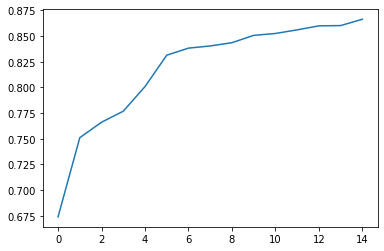

In [21]:
plt.plot(acc_seq2seq)

Finalmente luego de 15 epocas de entrenamiento, llegamos a buenos resultados y el accurracy dentro del set de entrenamiento empieza a converge a un 86,5%.  En un tiempo de entrenamiento relativamente bajo de 9 minutos. 

### Actividad 6

En esta sección se implmenra un modelo seq2seq pero esta vez con atención. Para lograr esto crearemos un modulo **AtentionDecoderModule** que a su vez usa el modulo **AttentionModule**, el cual permite calcular el resultado de atención dada una *Query*. Para Finalizar crearemos un Modulo **Seq2SeqAtention** que engloba al encoder antiguo y el decoder nuevo, y ajusta los parametros para que todo calze.

A continuación implementaremos un nuevo decoder que incluye atención:

* Es clave notar que el tamaño de la capa lineal es 2 veces el tamaño de la dimensión interna. esto es devido a que para hacer la predicción se usara el estado h_t (igual que antes) pero ademas se usara el resultado de la query O_t que tiene la misma dimensión que la dimensión interna.

* Como el el encoder es bidireccional entonces el tamaño de la dimension de ht que entrega sea 2 veces la dimensión interna del encoder. Por tanto devido a esto y a la concatenación de O_t la capa interna tiene una dimensión de input equivalente a 4 veces la capa interna del encoder. Lo cual explica el **aumento de parametros**.

In [0]:
class AtentionDecoderModule(nn.Module):
    def __init__( self, embeddings_table, embeddings_size, hidden_size, start_idx, dst_vocab_size ): 
        super().__init__()
        self.embeddings_table = embeddings_table 
        self.embeddings_size = embeddings_size 
        self.hidden_size = hidden_size 
        self.start_idx = torch.tensor(start_idx).to(device)
        # capa que mapee estado interno de decodificador a vocabulario de salida 
        self.W_vocab = torch.nn.Linear(hidden_size*2, dst_vocab_size) # TODO: completar parametros
      
        # decodificador recurrente
        self.lstm_cell = torch.nn.LSTMCell(input_size=embeddings_size, hidden_size=hidden_size) # TODO: completar parametros
        self.attention = AttentionModule(self.hidden_size)

    def forward( self, all_enc_hidden_states, final_enc_hidden_states, final_enc_cell_states, max_sentence_length, batch_size): 
        out = []
        coef = []
        # estado oculto (h, c) inicial para decodificador 
        state = (final_enc_hidden_states, final_enc_cell_states)
        # loop de decodificacion
        y_t = self.embeddings_table(self.start_idx.repeat(batch_size))
        for i in range(max_sentence_length):
            state = self.lstm_cell(y_t, state) 
            h_t, _ = state

            # obtener representacion batch*hidden usando atencion 
            O_t, A = self.attention(h_t, all_enc_hidden_states)
            # calular logits de salida usando W_vocab
            concat_input = torch.cat((h_t, O_t), -1) 
            P_t = self.W_vocab(concat_input) 
            out.append(P_t)
            coef.append(A) #para poder visualizar
            _, max_indices = P_t.max(dim=1) 
            y_t = self.embeddings_table(max_indices)
        
        return torch.stack(out, dim=1), torch.stack(coef, dim = 1)

Luego tambien implementamos el modulo de antencion

In [0]:
class AttentionModule(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

    def forward( self, h_t, all_enc_hidden_states):
        # TODO: completar return O_t
        soft = nn.Softmax(dim = 0)
        cos = nn.CosineSimilarity(dim=0, eps=1e-6)
        batch_len, seq_out_len, _ = all_enc_hidden_states.size()
        o_t = []
        A = [] #para poder visualizar
        for seq in range(batch_len):
            h_seq = h_t[seq]
            all_enc_seq  =  all_enc_hidden_states[seq]  
            seq_scores = []
            for h_i_seq in all_enc_seq:
              sim_i = torch.cosine_similarity(h_seq.view(1, -1), h_i_seq.view(1, -1))
              seq_scores.append(sim_i.item())
            seq_scores = soft(torch.tensor(seq_scores))
            A.append(seq_scores) #para poder visualizar
            o_i = torch.mm(seq_scores.unsqueeze(0), all_enc_seq)
            o_t.append(o_i.squeeze())
        o_t = torch.stack(o_t, dim=0)
        A = torch.stack(A, dim=0)
        return o_t, A


Finalmente es necesario hacer un nuevo modelo que incluya este nuevo decoder

In [0]:
class Seq2SeqAtention(nn.Module):

    def __init__(self, hidden_size, embedding_size, org_vocab_size, dst_vocab_size, start_idx):
      super().__init__()
      self.start_idx = start_idx
      self.hidden_size = hidden_size
      self.embedding_size = embedding_size
      self.inEmbedding = nn.Embedding(org_vocab_size, embedding_size)
      self.encoder = EncoderModule(self.inEmbedding, self.embedding_size, self.hidden_size)
      self.outEmbedding = nn.Embedding(dst_vocab_size, embedding_size)
      self.decoder = AtentionDecoderModule(self.outEmbedding, self.embedding_size,
                                           self.hidden_size*2, self.start_idx, 
                                           dst_vocab_size)
      self.coef = []
      
    def forward(self, input, max_sentence_length, get_coef = False):

      batch_size, in_seq_len = input.shape
      all_hidden_states, last_hidden_states, last_cell_states = self.encoder(input, in_seq_len)
      #print(f"all_hidden_states {all_hidden_states.size()} last_hidden_states {last_hidden_states.shape} ")
      out, coef = self.decoder(all_hidden_states, last_hidden_states,
                              last_cell_states, max_sentence_length, batch_size)
      if(get_coef):
          return out, coef
      return out

Luego Instanciamos un modelo de seq2seq con exactamente los mismos hiper-parametros que se usaron para la sección 4 y 5 (de tal forma de conseguir una mejor comparación). Como se Menciono al comienzo, Es claro que la cantidad de parametros aumenta, pero no de manera considerable. Pasando de **84041** a **85641**

In [0]:
HIDEN_SIZE = 50
EMBEDDING_SIZE = 25
ORG_VOCAB_SIZE = 17
DST_VOCAB_SIZE = 16
START_IDX = 1

seq2seqModelAt = Seq2SeqAtention(HIDEN_SIZE, EMBEDDING_SIZE, ORG_VOCAB_SIZE, DST_VOCAB_SIZE, START_IDX)

In [185]:
num_trainable_parameters(seq2seqModelAt)

85641

### Actividad 7

Finalmente devido a que ya teniamos la función `run2` podemos simplemente probar nuestro nuevo modelo con atención con la ayuda del dataloader **train_scan_dataloader**

In [229]:
acc_seq2seq = run2(seq2seqModelAt, train_scan_dataloader, n_epochs=3, verbose=False )

epoca 1
tiempo entrenamiento epoca: 540.0571279525757/ accurracy: 0.7038530748787276
epoca 2
tiempo entrenamiento epoca: 543.7837119102478/ accurracy: 0.747358181614797
epoca 3
tiempo entrenamiento epoca: 546.4147329330444/ accurracy: 0.7781016644012783


In [200]:
acc_seq2seq_2 = run2(seq2seqModelAt, train_scan_dataloader, n_epochs=5, verbose=False )

epoca 1
tiempo entrenamiento epoca: 545.5504794120789/ accurracy: 0.8226393428476018
epoca 2
tiempo entrenamiento epoca: 542.7610578536987/ accurracy: 0.8278766811426662
epoca 3
tiempo entrenamiento epoca: 546.3871471881866/ accurracy: 0.8296325765029368
epoca 4
tiempo entrenamiento epoca: 543.7127604484558/ accurracy: 0.8328133038326698
epoca 5
tiempo entrenamiento epoca: 542.0499656200409/ accurracy: 0.8320050296432459


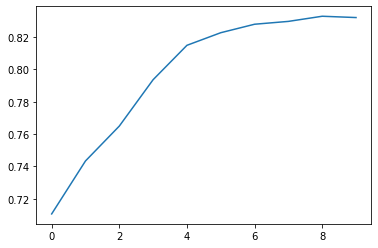

In [201]:
plt.plot(acc_seq2seq + acc_seq2seq_2)

Luego de realizar el entrenamiento, el modelo con atencón llego a un acurracy del 83% en tan solo 10 epocas. Lamentablemente con los **hiper-parametros utilizados**, el modelo de atención no logro un resultado considerablemente mejor, sin embargo, aumento el tiempo de entrenamiento Bastante. El aumento del tiempo tan drastico se deve al calculo del query, el cual ademas de ser costoso, podria estar mucho mejor implementado. 

### Actividad 8

Cargamos el set de testeo

In [0]:
testScanDataset = SimpleScanDataset("drive/My Drive/SCAN/tasks_test_simple.txt")
test_scan_dataloader = DataLoader(trainScanDataset, batch_size= 2,
                                   collate_fn= scan_collate, drop_last=True)

In [0]:
import pandas as pd
import numpy as np
def coef_to_df(coef, columns, index):
    rectangular = []
    for token in coef:
      rectangular.append(token.tolist())
    df = pd.DataFrame(np.array(rectangular), columns=columns, index=index) 
    return df

In [0]:
def get_prediction(X):
    rounded_preds = (torch.sigmoid(X))
    predc = []
    for idx in range(len(rounded_preds)):
      max_pred = torch.argmax(rounded_preds[idx])
      predc.append(max_pred.item())
    return predc  

In [0]:
def get_word(vocab, idx):
  for key, value in vocab.items():
    if idx == value:
      return key

In [239]:
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


batch size: 2 seq out len: 48
seq in len: 9
output shape torch.Size([2, 48, 16])
coef shaoe torch.Size([2, 48, 9])
48


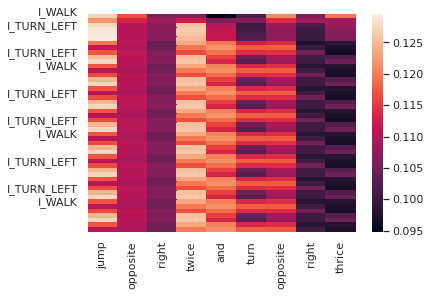

In [249]:
for batch in test_scan_dataloader:
    input_batch = batch["IN"]
    output_batch = batch["OUT"]
    batch_size, seq_out_len = output_batch.size()
    _, seq_in_len = input_batch.size()
    print("batch size:", batch_size, "seq out len:", seq_out_len)
    print("seq in len:", seq_in_len)
    output , coef = seq2seqModelAt2(input_batch, seq_out_len, get_coef = True)
    print("output shape", output.shape)
    print("coef shaoe", coef.shape)
    i = 0
    for seq in output:
      predc = get_prediction(seq)
      sample = [get_word(trainScanDataset.inVocab, idx) for idx in input_batch[i]]
      predc = [get_word(trainScanDataset.outVocab, idx) for idx in predc]
      print(len(predc))
      df = coef_to_df(coef[i], sample, predc)
      #print(df)
      ax = sns.heatmap(df)
      i += 1
      break
    break  